# Snekmer Demo

In this notebook, we will demonstrate how to apply Snekmer toward the analysis of protein sequences.

## Getting Started

### Setup

First, install Snekmer using the instructions in the [user installation guide](https://snekmer.readthedocs.io/en/latest/getting_started/install.html).

Before running Snekmer, verify that files have been placed in an **_input_** directory placed at the same level as the **_config.yaml_** file. The assumed file directory structure is illustrated below.

    .
    ├── config.yaml
    ├── input
    │   ├── background
    │   │   ├── X.fasta
    │   │   ├── Y.fasta
    │   │   └── etc.
    │   ├── A.fasta
    │   ├── B.fasta
    │   └── etc.
    ├── output
    │   ├── ...
    │   └── ...
    
(Note: Snekmer automatically creates the **_output_** directory when creating output files, so there is no need to create this folder in advance. Additionally, inclusion of background sequences is optional, but is illustrated above for interested users.)

To ensure that the tutorial runs correctly, activate the conda environment containing your Snekmer installation and run the notebook from the environment.

### Workflow

Snekmer proceeds through a defined workflow executed as individual steps on Snakemake. Two operation modes are available: `model` (supervised machine learning) and `cluster` (unsupervised clustering). The user should select the mode that best suits their individual use case.

<img src="https://raw.githubusercontent.com/PNNL-CompBio/Snekmer/main/resources/snekmer_workflow.svg" width="70%" height="70%" >



### Notes on Using Snekmer

Snekmer assumes that the user will primarily process input files using the command line. For more detailed instructions, refer to the [README](https://github.com/PNNL-CompBio/Snekmer).

The basic process for running Snekmer is as follows:

1. Verify that your file directory structure is correct and that the top-level directory contains a **_config.yaml_** file.
    - A **_config.yaml_** template has been included in the Snekmer codebase at **_resources/config.yaml_**.
2. Modify the **_config.yaml_** with the desired parameters.
3. Use the command line to navigate to the directory containing both the **_config.yaml_** file and **_input_** directory.
4. Run `snekmer cluster`, `snekmer model`, or `snekmer search`.

Depending on the selected operation mode, output files will vary.

In the following demo, we will go through the entire Snekmer workflow for supervised model-building (`snekmer model`). By the end of this demo, users should be familiar with how the code generally operates, how input files lead to output files, and the output for each individual step.

## Running Snekmer

### Setup

To set up the workflow such that operation mimics the command line implementation of Snekmer, we will initialize a dictionary (rather than a YAML file) and gather all input files. Input files are detected here using `glob.glob`, exactly as Snekmer performs input file detection.

In [1]:
# built-in imports
import itertools
import gzip
import json
import os
import pickle
from ast import literal_eval
from glob import glob
from datetime import datetime
from multiprocessing import Pool
from shutil import copy

# import from external libraries
import snekmer as skm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from snakemake.io import expand, directory

In [2]:
# define config
# (note: handled via config.yaml in the snekmer CLI workflow)

config = {
    
    # required parameters
    "k": 14,
    "alphabet": 0,  # choices 0-5 or names (see alphabet module), or None
    "min_rep_thresh": 1,
    "processes": 2,

    # input handling
    "input": {
        "example_index_file": False,
        "feature_set": False,
        "file_extensions": ["fasta", "fna", "faa", "fa"],
        "regex": r"[a-z]{3}[A-Z]{1}",  # regex to parse family from filename
    },
    
    # output handling
    "output": {
        "nested_dir": False,  # if True, saves into {save_dir}/{alphabet name}/{k}
        "verbose": True, # if True, logs verbose outputs
        "format": "simple",  # choices: ["simple", "gist", "sieve"]
        "filter_duplicates": True,
        "n_terminal_file": False,
        "shuffle_n": False,
        "shuffle_sequences": False,
    },
    
    # scoring parameters
    "score": {
        "scaler": True,
        "scaler_kwargs": {"n": 0.25},
        "labels": None,
        "lname": None  # label name
    },
    
    # model parameters
    "model": {
        "n": 100,
        "cv": 5,
        "use_score": False,
        "random_state": None
    },
    
    # cluster parameters
    "cluster": {
        "method": "correlation",
        "params": {"t": 0.75, "criterion": "distance", "metric": "correlation", "method": "weighted"}
    }

}

## Rule 0: Get files

Before going through the workflow, we glob all filenames contained within the input directory that end in the pre-defined file extensions and/or the extension and `.gz`.

Note that while in this notebook, the path to the demo files is specified with the `input_dir` variable, the Snekmer CLI assumes that input files are stored according to the file structure specified above in the **Setup** section.

In [3]:
# collect all fasta-like files, unzipped filenames, and basenames
input_dir = "input/"
input_files = glob(os.path.join(input_dir, "*"))
zipped = [fa for fa in input_files if fa.endswith(".gz")]
unzipped = [
    fa.rstrip(".gz")
    for fa, ext in itertools.product(input_files, config["input"]["file_extensions"])
    if fa.rstrip(".gz").endswith(f".{ext}")
]

print("zipped files:\t", zipped)
print("unzipped files:\t", unzipped)

zipped files:	 ['input/NapB.faa.gz']
unzipped files:	 ['input/cNorB.faa', 'input/NapB.faa', 'input/nirS.faa']


Next, file paths are stripped of directory paths and extensions into the file base name, known in Snakemake as a file"s **wildcard**.

In [4]:
# map extensions to basename (basename.ext.gz -> {basename: ext})
UZ_MAP = {
    skm.utils.split_file_ext(f)[0]: skm.utils.split_file_ext(f)[1] for f in zipped
}

FA_MAP = {
    skm.utils.split_file_ext(f)[0]: skm.utils.split_file_ext(f)[1] for f in unzipped
}

UZS = [f"{f}.{ext}" for f, ext in UZ_MAP.items()]
FAS = list(FA_MAP.keys())

print("zipped filename wildcards:\t", UZS)
print("unzipped filename wildcards:\t", FAS)

zipped filename wildcards:	 ['NapB.faa']
unzipped filename wildcards:	 ['cNorB', 'NapB', 'nirS']


In [5]:
# parse any background files
bg_files = glob(os.path.join(input_dir, "background", "*"))
if len(bg_files) > 0:
    bg_files = [skm.utils.split_file_ext(basename(f))[0] for f in bg_files]
NON_BGS, BGS = [f for f in FAS if f not in bg_files], bg_files

print("sample filename wildcards:\t", NON_BGS)
print("background filename wildcards:\t", BGS)

sample filename wildcards:	 ['cNorB', 'NapB', 'nirS']
background filename wildcards:	 []


Finally, the output (save) path is defined. (Note: this may change in future versions.)

In [6]:
# define output directory (and create if missing)
output_dir = "output"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("output directory:\t", output_dir)

# validity check
skm.alphabet.check_valid(config["alphabet"])  # raises error if invalid alphabet

output directory:	 output


## Rule 0.5: Unzip files

Any zipped files detected by the above are automatically unzipped. The zipped version of the file is copied into a separate subdirectory.

**Snakemake code:**

    # if any files are gzip compressed, unzip them
    rule unzip:
    input:
        join("input", "{uz}.gz")
    output:
        join("input", "{uz}")
    params:
        outdir=join("input", "zipped")
    shell:
        "mkdir {params.outdir} && gunzip -c {input} > {output} && mv {input} {params.outdir}/."
                
To run an analogous version of Snakemake syntax in Python, see below:

In [19]:
# reset demo files
for uz in UZS:
    input_ = os.path.join(input_dir, f"{uz}.gz")
    output_unzipped = os.path.join(input_dir, f"{uz}")
    output_zipped = os.path.join(input_dir, "zipped", f"{uz}.gz")
    
    # copy zipped file back to input folder and delete
    copy(output_zipped, input_)
    os.remove(output_zipped)
    os.remove(output_unzipped)
    os.rmdir(os.path.dirname(output_zipped))


In [20]:
# if any files are gzip compressed, unzip them
for uz in UZS:
    input_ = os.path.join(input_dir, f"{uz}.gz")
    output_unzipped = os.path.join(input_dir, f"{uz}")
    output_zipped = os.path.join(input_dir, "zipped", f"{uz}.gz")
    
    # preserve zipped file
    if not os.path.exists(os.path.dirname(output_zipped)):
        os.makedirs(os.path.dirname(output_zipped))
    copy(input_, output_zipped)

    # unzip and save file contents
    with gzip.open(input_, "rb") as openf, open(output_unzipped, "wb") as savef:
        file_content = openf.readlines()
        for line in file_content:
            savef.write(line)

    os.remove(input_)

    print("input:\t", input_)
    print("output:\t", output_unzipped)

input:	 input/NapB.faa.gz
output:	 input/NapB.faa


## Rule 1: Preprocess

In this step, we parse user-defined parameters into an appropriate format for subsequent pipeline steps.

Parameter options include:
- `k`: Define kmer length
- `alphabet`: Define the translation alphabet

The Snakemake code is not shown due to length, but the converted Python-ized code is shown below:

In [21]:
for fa in unzipped:
    # this is handled by snakemake but we'll specify it here
    output_kmerobj = os.path.join(output_dir, "kmerize", f'{skm.utils.split_file_ext(fa)[0]}.kmers')
    if not os.path.exists(os.path.join(output_dir, "kmerize")):
        os.makedirs(os.path.join(output_dir, "kmerize"))
        
    output_data = os.path.join(output_dir, "vector", f'{skm.utils.split_file_ext(fa)[0]}.npz')
    
    if not os.path.exists(os.path.join(output_dir, "vector")):
        os.mkdir(os.path.join(output_dir, "vector"))

    # read seqs file and initialize kmerization object
    fasta = SeqIO.parse(fa, "fasta")
    kmer = skm.vectorize.KmerVec(alphabet=config["alphabet"], k=config["k"])

    vecs, seqs, ids, lengths = list(), list(), list(), list()
    for f in fasta:
        vecs.append(kmer.reduce_vectorize(f.seq))
        seqs.append(
            skm.vectorize.reduce(
                f.seq,
                alphabet=config["alphabet"],
                mapping=skm.alphabet.FULL_ALPHABETS,
            )
        )
        ids.append(f.id)
        lengths.append(len(f.seq))

    # save seqIO output and transformed vecs
    np.savez_compressed(output_data, ids=ids, seqs=seqs, vecs=vecs, lengths=lengths)

    with open(output_kmerobj, "wb") as f:
        pickle.dump(kmer, f)

/Users/chan898/miniconda3/envs/snekmer/lib/python3.10/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


## Rule 4: Score features

In this penultimate step, the files parsed into each feature space are scored for their faithful differentiation of each protein family, and then clustering is performed on the individual sequences. The results are all collated and stored into a Pandas DataFrame (`pandas.DataFrame` object).

As previously, the Python-ized version of this Snakemake rule is demonstrated below:

In [24]:
FAS

['cNorB', 'NapB', 'nirS']

In [30]:
input_data, input_kmerobj

('output/vector/cNorB.npz', 'output/kmerize/cNorB.kmers')

In [41]:
from typing import Dict

def load_npz(
    filename: str,
    columns: Dict[str, str] = {
        "ids": "sequence_id",
        "seqs": "sequence",
        "vecs": "sequence_vector",
    },
) -> pd.DataFrame:
    """Compile .npz results into dataframe.

    Parameters
    ----------
    filename : str
        /path/to/filename for input .npz file.
    columns : Dict[str, str]
        Mapping for output data column names (the default is
            {
                "ids": "sequence_id",
                "seqs": "sequence",
                "vecs": "sequence_vector",
            }
        ).

    Returns
    -------
    pd.DataFrame
        Tabulated .npz data.

    """
    data = np.load(filename, allow_pickle=True)

    # fill in df based on desired output col names
    df = {"filename": os.path.splitext(os.path.basename(filename))[0]}

    for in_col, out_col in columns.items():
        df.update({out_col: list(data[in_col])})

        # get seq column for sequence lengths
        if "seq" in in_col:
            df.update({f"{out_col}_length": [len(s) for s in data[in_col]]})

    return pd.DataFrame(df)

In [44]:
data = np.load(input_data, allow_pickle=True)
data

In [ ]:
columns = {
    "ids": "sequence_id",
    "seqs": "sequence",
    "vecs": "sequence_vector",
}

for in_col, out_col in columns.items():
    print()

In [31]:
# load all kmer and vector data for demo files
data = list()
for fa in FAS:
    start_time = datetime.now()
    label = (
        config["score"]["lname"]
        if str(config["score"]["lname"]) != "None"
        else "label"
    )  # e.g. "family"
    print(f"start time:\t{start_time}\n")

    # input/output file handling (performed via Snakemake in Snekmer)
    input_kmerobj = os.path.join(output_dir, "kmerize", f"{fa}.kmers")
    input_data = os.path.join(output_dir, "vector", f"{fa}.npz")
        
    # get kmers for this particular set of sequences
    kmer = skm.io.load_pickle(input_kmerobj)

    # tabulate vectorized seq data
    data.append(skm.io.load_npz(input_data))

# concatenate all demo file data
data = pd.concat(data, ignore_index=True)
data["background"] = [f in BGS for f in data["filename"]]

# log conversion step runtime
timepoint = datetime.now()
print(f"files_to_df:\t{timepoint}")
print(f"start time -> files_to_df:\t{skm.utils._format_timedelta(timepoint - start_time)}\n")

# parse family names and only add if some are valid
families = [
    skm.utils.get_family(
        skm.utils.split_file_ext(fn)[0], regex=config["input_file_regex"]
    )
    for fn in data["filename"]
]
if any(families):
    data[label] = families

# binary T/F for classification into family
family = skm.utils.get_family(wildcards.nb)
binary_labels = [True if value == family else False for value in data[label]]

# define k-fold split indices
if config["model"]["cv"] > 1:
    cv = StratifiedKFold(n_splits=config["model"]["cv"], shuffle=True)

    # stratify splits by [0,1] family assignment
    for n, (i_train, _) in enumerate(
        cv.split(data["sequence_vector"], binary_labels)
    ):
        data[f"train_cv-{n + 1:02d}"] = [idx in i_train for idx in data.index]

elif config["model"]["cv"] in [0, 1]:
    i_train, _ = train_test_split(data.index, stratify=binary_labels)
    data["train"] = [idx in i_train for idx in data.index]

# generate family scores and object
scorer = skm.score.KmerScorer()
scorer.fit(
    list(kmer.kmer_set.kmers),
    data,
    skm.utils.get_family(wildcards.nb, regex=config["input_file_regex"]),
    label_col=label,
    vec_col="sequence_vector",
    **config["score"]["scaler_kwargs"],
)

# append scored sequences to dataframe
data = data.merge(
    pd.DataFrame(scorer.scores["sample"]), left_index=True, right_index=True
)
if data.empty:
    raise ValueError("Blank df")

# save score loadings
class_probabilities = (
    pd.DataFrame(scorer.probabilities, index=scorer.kmers.basis)
    .reset_index()
    .rename(columns={"index": "kmer"})
)

# log time to compute class probabilities
timepoint = datetime.now()
print(f"class_probabilities:\t{timepoint}")
print(f"start time -> class_probabilities:\t{skm.utils._format_timedelta(timepoint - start_time)}\n")

# save all files to respective outputs
delete_cols = ["vec", "sequence_vector"]
for col in delete_cols:
    if col in class_probabilities.columns:
        class_probabilities = class_probabilities.drop(columns=col)
data.drop(columns="sequence_vector").to_csv(
    output.data, index=False, compression="gzip"
)
class_probabilities.to_csv(output.weights, index=False, compression="gzip")
with open(output.scorer, "wb") as f:
    pickle.dump(scorer, f)

# record script endtime
timepoint = datetime.now()
print(f"end time:\t{timept}")

start time:	2022-09-21 13:54:24.009925



ValueError: Object arrays cannot be loaded when allow_pickle=False

The contents of one of these dataframes is as follows:

In [14]:
example_family = 'cNorB'# np.random.choice(FAS)
print("example family:\t", example_family)

# show relevant subset of columns
example_score_output = pd.read_csv(
    os.path.join(output_dir, "features", f"{example_family}.csv.gz")
)[["filename", "seq_id", "family", f"{example_family}_score"]]
example_score_output

example family:	 cNorB


,filename,seq_id,family,cNorB_score
0,cNorB.json.gz,WP_004255833.1,cNorB,0.788182
1,cNorB.json.gz,WP_043108184.1,cNorB,0.745808
2,cNorB.json.gz,WP_011311073.1,cNorB,0.811925
3,cNorB.json.gz,WP_014238124.1,cNorB,0.773484
4,cNorB.json.gz,WP_013029258.1,cNorB,0.717490
...,...,...,...,...
615,nirS.json.gz,WP_011383805.1,nirS,0.036300
616,nirS.json.gz,WP_049724801.1,nirS,0.056875
617,nirS.json.gz,WP_041099757.1,nirS,0.037763
618,nirS.json.gz,WP_015258444.1,nirS,0.059967


Text(0, 0.5, 'cNorB Score')

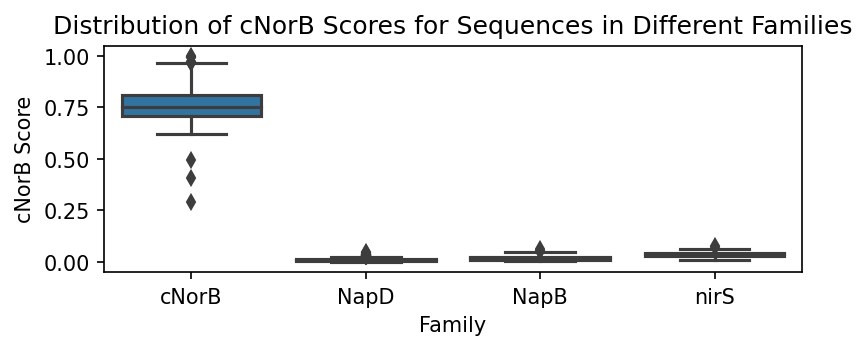

In [15]:
plt.figure(figsize=(6, 2), dpi=150)
ax = sns.boxplot(x="family", y=f"{example_family}_score", data=example_score_output)

ax.set_title(
    f"Distribution of {example_family} Scores for Sequences in Different Families"
)
ax.set_xlabel("Family")
ax.set_ylabel(f"{example_family} Score")

We can assess how well the scores perform using the weights determined for each family. Note that it is immediately obvious that the `cNorB` scoring method performs well in identifying cNorB sequences versus the NapD, NapB, and nirS sequences.

Not all family scoring methods perform similarly well in terms of differentation between sequences belonging to different families. The user can manually inspect the other families, but we note that the NapD family and NapB family scorers are worse at generating high separation between the in-family and out-of-family sequences. Differing scorer performances can be attributed to a variety of factors, e.g. parameters such as the alphabet and k, existing levels of similarity between sequences in different families, etc.

The probabilities and scores assigned to each feature in the kmer set is also computed and output into a dataframe:

In [16]:
print(example_family)
pd.read_csv(os.path.join(output_dir, "score", "weights", f"{example_family}.csv.gz"))

cNorB


,kmer,sample,background
0,VSSSSSVVVVSSSV,0.014936,NaN
1,SSSSSVVVVSSSVV,0.205204,NaN
2,SSSSVVVVSSSVVV,0.206522,NaN
3,SSSVVVVSSSVVVV,0.141304,NaN
4,SSVVVVSSSVVVVV,0.141304,NaN
...,...,...,...
6518,SVSSSVSVSSSSSS,-0.031662,NaN
6519,VSSSVSVSSSSSSS,-0.036418,NaN
6520,SSSVSVSSSSSSSS,-0.047746,NaN
6521,VSVSSSVSVVSVVS,0.004067,NaN


## Rule 5: Build supervised machine learning models

Finally, models are constructed which accept the pre-determined family scores as input and train logistic regression models to output putative in-family assignment for a given sequence. The model can also be used to approximate the probability that a given sequence belongs to the family of interest.

Each model is further validated using K-fold cross-validation, and the results from each cross-validation split are summarized in figures depicting the Receiver-Operator Characteristics (ROC) Curve and Precision-Recall (PR) Curve. In the following example, `K=5`.

The code, as adapted for presentation in a Jupyter notebook, is included below:

input files:	 [['demo_files/output/features/cNorB/cNorB.json.gz', 'demo_files/output/features/cNorB/NapD.json.gz', 'demo_files/output/features/cNorB/NapB.json.gz', 'demo_files/output/features/cNorB/nirS.json.gz'], 'demo_files/output/features/cNorB.csv.gz', 'demo_files/output/score/cNorB.csv.gz', 'demo_files/output/labels/cNorB.txt']
output files:	 ['demo_files/output/model/results/cNorB.csv', 'demo_files/output/model/cNorB.pkl']
start time:	2022-03-15 17:00:33.042393


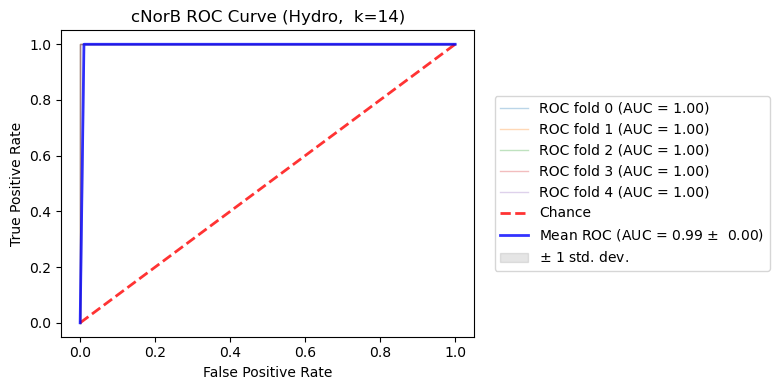

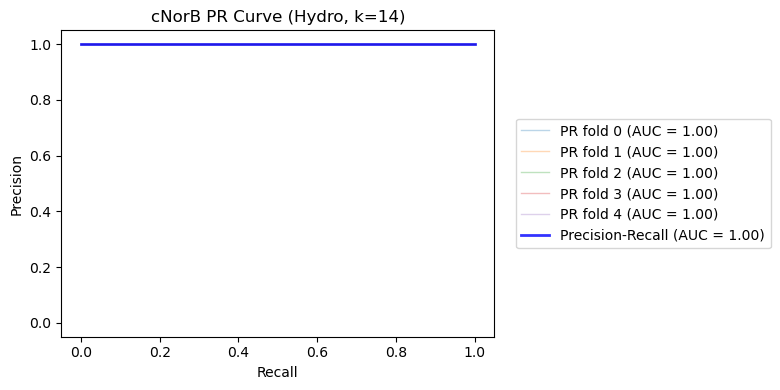

end time:	2022-03-15 17:00:50.303306
total time:	0h 00m 17.261s

input files:	 [['demo_files/output/features/NapD/cNorB.json.gz', 'demo_files/output/features/NapD/NapD.json.gz', 'demo_files/output/features/NapD/NapB.json.gz', 'demo_files/output/features/NapD/nirS.json.gz'], 'demo_files/output/features/NapD.csv.gz', 'demo_files/output/score/NapD.csv.gz', 'demo_files/output/labels/NapD.txt']
output files:	 ['demo_files/output/model/results/NapD.csv', 'demo_files/output/model/NapD.pkl']
start time:	2022-03-15 17:00:50.303793


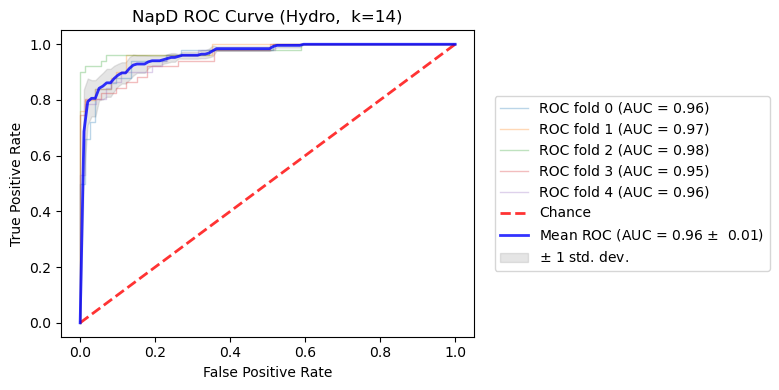

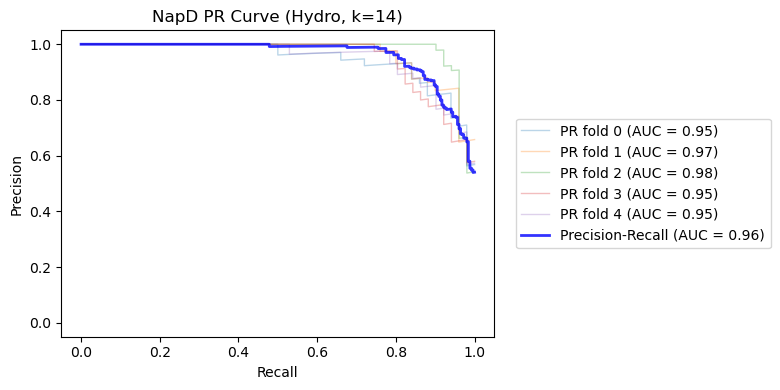

end time:	2022-03-15 17:01:15.772388
total time:	0h 00m 25.469s

input files:	 [['demo_files/output/features/NapB/cNorB.json.gz', 'demo_files/output/features/NapB/NapD.json.gz', 'demo_files/output/features/NapB/NapB.json.gz', 'demo_files/output/features/NapB/nirS.json.gz'], 'demo_files/output/features/NapB.csv.gz', 'demo_files/output/score/NapB.csv.gz', 'demo_files/output/labels/NapB.txt']
output files:	 ['demo_files/output/model/results/NapB.csv', 'demo_files/output/model/NapB.pkl']
start time:	2022-03-15 17:01:15.772820


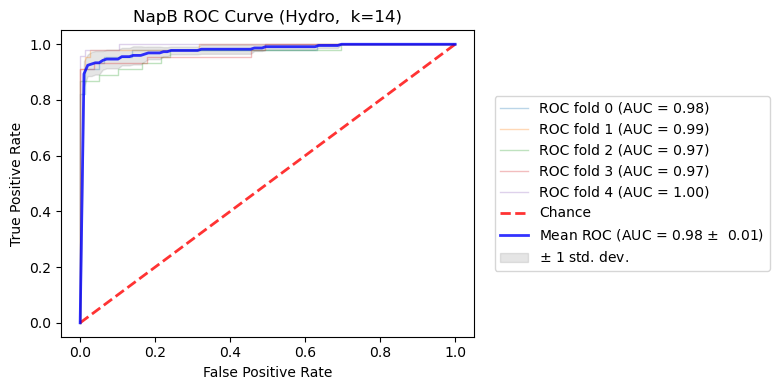

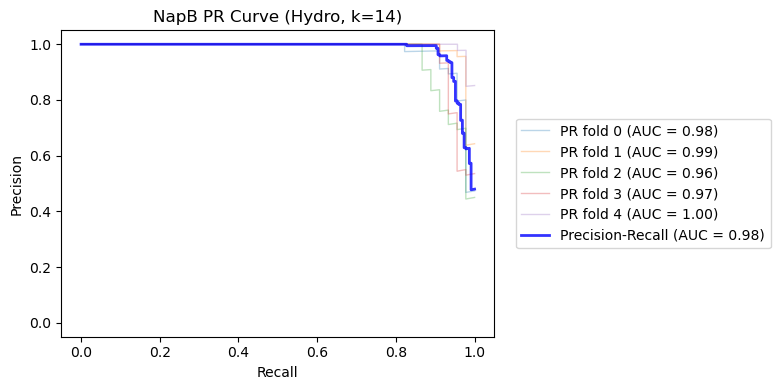

end time:	2022-03-15 17:01:40.242319
total time:	0h 00m 24.469s

input files:	 [['demo_files/output/features/nirS/cNorB.json.gz', 'demo_files/output/features/nirS/NapD.json.gz', 'demo_files/output/features/nirS/NapB.json.gz', 'demo_files/output/features/nirS/nirS.json.gz'], 'demo_files/output/features/nirS.csv.gz', 'demo_files/output/score/nirS.csv.gz', 'demo_files/output/labels/nirS.txt']
output files:	 ['demo_files/output/model/results/nirS.csv', 'demo_files/output/model/nirS.pkl']
start time:	2022-03-15 17:01:40.242763


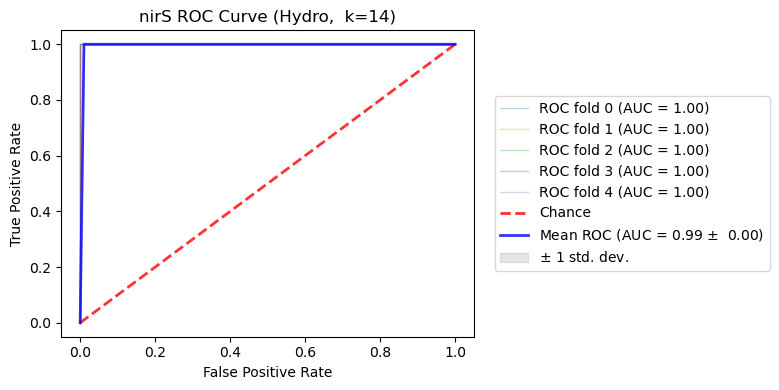

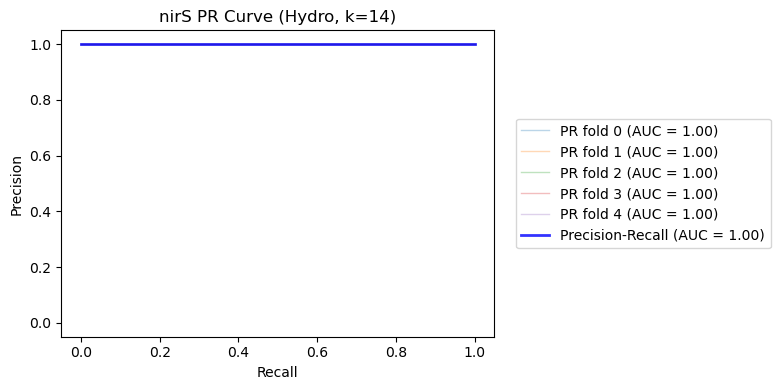

end time:	2022-03-15 17:01:57.756822
total time:	0h 00m 17.514s



In [17]:
for fa in FAS:
    # define all input and output files
    input_files = expand(
        os.path.join(output_dir, "features", f"{fa}", "{fa2}.json.gz"), fa2=FAS
    )
    input_data = os.path.join(output_dir, "features", f"{fa}.csv.gz")
    input_scores = os.path.join(output_dir, "score", "weights", f"{fa}.csv.gz")
    input_kmers = os.path.join(output_dir, "labels", f"{fa}.txt")
    output_model = os.path.join(output_dir, "model", f"{fa}.pkl")
    output_results = os.path.join(output_dir, "model", "results", f"{fa}.csv")
    print("input files:\t", [input_files, input_data, input_scores, input_kmers])
    print("output files:\t", [output_results, output_model])

    if not os.path.exists(os.path.join(output_dir, "model", "results")):
        os.makedirs(os.path.join(output_dir, "model", "results"))

    start_time = datetime.now()
    print(f"start time:\t{start_time}")

    # load all input data and encode rule-wide variables
    data = pd.read_csv(input_data)
    data["vector"] = [
        literal_eval(vec) if isinstance(vec, str) else vec for vec in data["vector"]
    ]
    scores = pd.read_csv(input_scores)
    family = skm.utils.get_family(
        skm.utils.split_file_ext(input_scores)[0], regex=config["input"]["regex"]
    )
    kmers = skm.io.read_output_kmers(input_kmers)
    all_families = [
        skm.utils.get_family(
            skm.utils.split_file_ext(f)[0], regex=config["input"]["regex"]
        )
        for f in input_files
    ]
    cv = config["model"]["cv"]

    # process vector data
    label = "family"

    # prevent kmer NA being read as np.nan
    if config["k"] == 2:
        scores["kmer"] = scores["kmer"].fillna("NA")

    # get alphabet name
    if config["alphabet"] in skm.alphabet.ALPHABET_ORDER.keys():
        alphabet_name = skm.alphabet.ALPHABET_ORDER[config["alphabet"]].capitalize()
    else:
        alphabet_name = str(config["alphabet"]).capitalize()

    # create dataframe skeleton for AUC per family
    results = {
        "family": [],
        "alphabet_name": [],
        "k": [],
        "scoring": [],
        "score": [],
        "cv_split": [],
    }

    # generate [0, 1] labels for binary family assignment
    binary_labels = [True if value == family else False for value in data["family"]]
    le = LabelEncoder()
    le.fit(binary_labels)

    # set and format input and label arrays; initialize model objs
    X_all = data[f"{family}_score"].values.reshape(-1, 1)
    y_all = le.transform(binary_labels).ravel()

    # set random seed if specified
    rng = np.random.default_rng()
    random_state = rng.integers(low=0, high=32767)  # max for int16
    if str(config["model"]["random_state"]) != "None":
        random_state = config["model"]["random_state"]

    # set and format input and label arrays; initialize model objs
    X, y = {i: {} for i in range(cv)}, {i: {} for i in range(cv)}
    for n in range(cv):

        # remove score cols that were generated from full dataset
        unscored_cols = [col for col in list(data.columns) if "_score" not in col]

        # filter data by training data per split
        i_train = data[data[f"train_cv-{n + 1:02d}"]].index
        i_test = data[~data[f"train_cv-{n + 1:02d}"]].index
        df_train = data.iloc[i_train][unscored_cols].reset_index(drop=True)
        df_test = data.iloc[i_test][unscored_cols].reset_index(drop=True)
        df_train_labels = [
            True if value == family else False for value in df_train["family"]
        ]
        df_test_labels = [
            True if value == family else False for value in df_test["family"]
        ]

        # score kmers separately per split
        scorer = skm.model.KmerScorer()
        scorer.fit(
            kmers,
            df_train,
            family,
            label_col=label,
            **config["score"]["scaler_kwargs"],
        )

        # append scored sequences to dataframe
        df_train = df_train.merge(
            pd.DataFrame(scorer.scores["sample"]), left_index=True, right_index=True
        )
        if df_train.empty:
            raise ValueError("Blank df")
        df_test = df_test.merge(
            pd.DataFrame(
                scorer.predict(skm.model.to_feature_matrix(df_test["vector"]), kmers)
            ),
            left_index=True,
            right_index=True,
        ).rename(columns={0: f"{family}_score"})

        # save score loadings
        scores = (
            pd.DataFrame(scorer.probabilities, index=scorer.kmers.basis)
            .reset_index()
            .rename(columns={"index": "kmer"})
        )

        # save X,y array data for plot
        X[n]["train"] = df_train[f"{family}_score"].values.reshape(-1, 1)
        y[n]["train"] = le.transform(df_train_labels).ravel()

        X[n]["test"] = df_test[f"{family}_score"].values.reshape(-1, 1)
        y[n]["test"] = le.transform(df_test_labels).ravel()

    # ROC-AUC figure
    clf = LogisticRegression(
        random_state=random_state, solver="liblinear", class_weight="balanced"
    )
    fig, ax, auc_rocs = skm.plot.cv_roc_curve(
        clf,
        X,
        y,
        title=(f"{family} ROC Curve ({alphabet_name},  k={config['k']})"),
        dpi=100,
    )

    # collate ROC-AUC results
    results["family"] += [family] * cv
    results["alphabet_name"] += [alphabet_name.lower()] * cv
    results["k"] += [config["k"]] * cv
    results["scoring"] += ["roc_auc"] * cv
    results["score"] += auc_rocs
    results["cv_split"] += [i + 1 for i in range(cv)]

    # display and ROC-AUC figure
    plt.tight_layout()
    plt.show()

    # PR-AUC figure
    fig, ax, pr_aucs = skm.plot.cv_pr_curve(
        clf,
        X,
        y,
        title=(f"{family} PR Curve ({alphabet_name}, k={config['k']})"),
        dpi=100,
    )

    # collate PR-AUC results
    results["family"] += [family] * cv
    results["alphabet_name"] += [alphabet_name.lower()] * cv
    results["k"] += [config["k"]] * cv
    results["scoring"] += ["pr_auc"] * cv
    results["score"] += pr_aucs
    results["cv_split"] += [i + 1 for i in range(cv)]

    # display PR-AUC figure
    plt.tight_layout()
    plt.show()

    # save model
    clf.fit(X_all, y_all)
    with open(output_model, "wb") as save_model:
        pickle.dump(clf, save_model)

    # save full results
    pd.DataFrame(results).to_csv(output_results, index=False)

    # record script runtime
    end_time = datetime.now()
    print(f"end time:\t{end_time}")
    print(f"total time:\t{skm.utils.format_timedelta(end_time - start_time)}\n")


The models are objects stored as pickle files (.PKL) that can be applied elsewhere, e.g. to a new set of unknown sequences.

# Snekmer Search Mode

Say a user trains the four models above, and would then like to score and evaluate sequences with unknown family assignments. The user can use `snekmer search`, which uses the kmer basis set for the desired family to create kmer vectors for unknown sequences, then apply the family scorer to the vectorized unknown sequences, and finally use the model to predict family assignments for the unknown sequences.

These steps are illustrated below:

In [24]:
families = [
    skm.utils.get_family(
        skm.utils.split_file_ext(fa)[0], regex=config["input"]["regex"]
    )
    for fa in FAS
]

for fam in families:
    print("family:\t", fam)
    start_time = datetime.now()
    print(f"start time:\t{start_time}")

    # define the basis set for the example family
    input_basis = os.path.join("demo_files", "output", "labels", f"{fam}.txt")
    basis = skm.io.read_output_kmers(input_basis)

    # define set of unknown vectors
    input_fastas = glob(os.path.join("demo_files", "search", "input", "*.fasta"))
    output_features = os.path.join("demo_files", "search", "output", "features", fam)
    if not os.path.exists(output_features):
        os.makedirs(output_features)

    # load pre-trained scorer and model
    input_model = os.path.join("demo_files", "output", "model", f"{fam}.pkl")
    with open(input_model, "rb") as mf:
        model = pickle.load(mf)
    input_scorer = os.path.join("demo_files", "output", "score", f"{fam}.pkl")
    with open(input_scorer, "rb") as sf:
        scorer = pickle.load(sf)

    # define collated family model result output
    output_results = os.path.join("demo_files", "search", "output", "search", f"{fam}.csv")
    if not os.path.exists(os.path.dirname(output_results)):
        os.makedirs(os.path.dirname(output_results))

    # STEP 1: build kmer vectors according to new family basis set
    results = list()
    for i, fasta in enumerate(input_fastas):
        f = skm.utils.get_family(skm.utils.split_file_ext(fasta)[0], regex=config["input"]["regex"])
    
        vec_results = {"seq_id": [], "vector": []}
        seq_list, id_list = skm.io.read_fasta(fasta)
        
        for seq, sid in zip(seq_list, id_list):
            vec_results["seq_id"] += [sid]
            vec_results["vector"] += [
                skm.transform.vectorize_string(
                    seq,
                    config["k"],
                    params["alphabet"],
                    start=config["start"],
                    end=config["end"],
                    filter_list=basis,
                    verbose=False,  # suppress for batch processing
                )
            ]
        with gzip.open(os.path.join(output_features, f"{f}.json.gz"), "wt", encoding="ascii") as zipfile:
            json.dump(vec_results, zipfile)
            
        
        df = pd.DataFrame(vec_results)
        vecs = skm.utils.to_feature_matrix(df["vector"].values)

        # score unknown sequences using pre-trained scorer
        scores = scorer.predict(vecs, basis)

        # predict probabilities and classes of new vecs using model
        predictions = model.predict(scores.reshape(-1, 1))
        predicted_probas = model.predict_proba(scores.reshape(-1, 1))

        # display results (score, family assignment, and probability)
        df[f"{fam}_score"] = scores  # scorer output
        df[fam] = [True if p == 1 else False for p in predictions]
        df[f"{fam}_probability"] = [p[1] for p in predicted_probas]
        df["filename"] = os.path.basename(fasta)
        results.append(df)

    results = pd.concat(results, ignore_index=True).drop(columns=['vector'])
    results.to_csv(output_results, index=False)
    
    # record script runtime
    end_time = datetime.now()
    print(f"end time:\t{end_time}")
    print(f"total time:\t{skm.utils.format_timedelta(end_time - start_time)}\n")

family:	 cNorB
start time:	2022-03-16 09:55:17.791642
end time:	2022-03-16 09:55:20.247583
total time:	0h 00m 02.456s

family:	 NapD
start time:	2022-03-16 09:55:20.247792
end time:	2022-03-16 09:55:24.291122
total time:	0h 00m 04.43s

family:	 NapB
start time:	2022-03-16 09:55:24.291281
end time:	2022-03-16 09:55:28.031143
total time:	0h 00m 03.740s

family:	 nirS
start time:	2022-03-16 09:55:28.031352
end time:	2022-03-16 09:55:30.382982
total time:	0h 00m 02.352s



In [26]:
print("example family:\t", example_family)
pd.read_csv(os.path.join("demo_files", "search", "output", "search", f"{example_family}.csv"))

example family:	 cNorB


,seq_id,cNorB_score,cNorB,cNorB_probability,filename
0,WP_006484650.1,0.007890,False,0.051469,three.fasta
1,WP_006484654.1,0.004527,False,0.050095,three.fasta
2,WP_006484657.1,0.000893,False,0.048649,three.fasta
3,WP_006484664.1,0.078243,False,0.089690,three.fasta
4,WP_006484673.1,0.023950,False,0.058538,three.fasta
5,WP_006484674.1,0.036273,False,0.064569,three.fasta
6,WP_006484682.1,0.000000,False,0.048300,three.fasta
7,WP_004186391.1,0.010123,False,0.052402,one.fasta
8,WP_004186661.1,0.005337,False,0.050423,one.fasta
9,WP_004186709.1,0.000794,False,0.048610,one.fasta


In this example application, none of the sequences contained in any of the three unknown files are predicted to belong to the example family, cNorB. The family probability scores themselves (see column: **cNorB_probability**) are very low.